In [3]:
# Core
import os, glob, re, warnings
from pathlib import Path

import numpy as np
import pandas as pd

# ML / preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

pd.set_option("display.max_columns", 100)
warnings.filterwarnings("ignore")

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0-rc0


In [4]:
DATA_PATH = "Churn_Modelling.csv"   

# auto-detect typical names if DATA_PATH not found ===
def auto_find_csv():
    pats = ["*Churn*.csv", "*Modelling*.csv", "*.csv"]
    for pat in pats:
        hits = glob.glob(pat) + glob.glob(os.path.join("*", pat))
        if hits:
            return hits[0]
    return None

if not os.path.exists(DATA_PATH):
    guess = auto_find_csv()
    if guess:
        DATA_PATH = guess

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError("CSV not found. Set DATA_PATH to your dataset file (e.g., 'Churn_Modelling.csv').")

raw_df = pd.read_csv(DATA_PATH)
raw_df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
def to_snake(name: str) -> str:
    n = name.strip()
    n = n.replace(" ", "_")
    n = n.replace("-", "_")
    # common exact names from spec
    n = n.replace("Row_number", "RowNumber").replace("Customer_ID", "CustomerId").replace("Credit_Score","CreditScore")
    n = n.replace("NumOfProducts","NumOfProducts").replace("HasCrCard","HasCrCard").replace("IsActiveMember","IsActiveMember")
    # fix the typo exactly as given
    n = n.replace("Geograpgy", "Geography")
    # final: snake
    n = re.sub("([a-z0-9])([A-Z])", r"\1_\2", n)   # camelCase → snake_case
    return n.lower()

df = raw_df.copy()
df.columns = [to_snake(c) for c in df.columns]

print("Columns after normalization:\n", list(df.columns))
df.head(3)


Columns after normalization:
 ['row_number', 'customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']


,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [6]:
print("Null counts BEFORE preprocessing:\n", df.isna().sum())

Null counts BEFORE preprocessing:
 row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64


In [7]:
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Duplicate rows removed: {before - after}")

# drop index/id/name-like columns (not predictive)
drop_cols = ['row_number', 'customer_id', 'surname']
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

print("Remaining columns:", list(df.columns))
df.head(3)


Duplicate rows removed: 0
Remaining columns: ['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']


,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [8]:
if "exited" not in df.columns:
    raise KeyError("Target column 'Exited' (as 'exited') not found!")

X = df.drop(columns=["exited"])
y = df["exited"].astype(int)

print("X shape:", X.shape)
print("y value counts:\n", y.value_counts())


X shape: (10000, 10)
y value counts:
 exited
0    7963
1    2037
Name: count, dtype: int64


In [9]:
# identify column types
categorical_cols = [c for c in X.columns if X[c].dtype == "object"]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)

# pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))  # keep all levels
])

# combine
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop",
)


Categorical: ['geography', 'gender']
Numeric: ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary']


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

# fit on train, transform both
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

# ensure dense arrays for Keras
if hasattr(X_train_prep, "toarray"):
    X_train_prep = X_train_prep.toarray()
if hasattr(X_test_prep, "toarray"):
    X_test_prep = X_test_prep.toarray()

X_train_prep = X_train_prep.astype("float32")
X_test_prep  = X_test_prep.astype("float32")

print("Prepared shapes:", X_train_prep.shape, X_test_prep.shape)


Prepared shapes: (8000, 13) (2000, 13)


In [11]:
input_dim = X_train_prep.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=8, mode="max", restore_best_weights=True
)

history = model.fit(
    X_train_prep, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

best_val_acc = max(history.history["val_accuracy"])
print(f"Best Val Accuracy: {best_val_acc:.4f}")


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.7792 - loss: 0.5444 - val_accuracy: 0.8000 - val_loss: 0.4816
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7961 - loss: 0.4812 - val_accuracy: 0.7987 - val_loss: 0.4477
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8016 - loss: 0.4477 - val_accuracy: 0.8087 - val_loss: 0.4312
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8034 - loss: 0.4391 - val_accuracy: 0.8194 - val_loss: 0.4227
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8052 - loss: 0.4353 - val_accuracy: 0.8263 - val_loss: 0.4156
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8128 - loss: 0.4329 - val_accuracy: 0.8363 - val_loss: 0.4092
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8173 - loss: 0.4230 - val_accuracy: 0.8400 - val_loss: 0.4026
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8234 - loss: 0.4115 - val_accuracy: 0.

In [15]:
y_proba = model.predict(X_test_prep).ravel()
y_pred = (y_proba >= 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nTest Accuracy:", round(accuracy_score(y_test, y_pred), 4))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step   
Confusion Matrix:
 [[1539   54]
 [ 219  188]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8754    0.9661    0.9185      1593
           1     0.7769    0.4619    0.5794       407

    accuracy                         0.8635      2000
   macro avg     0.8261    0.7140    0.7489      2000
weighted avg     0.8554    0.8635    0.8495      2000


Test Accuracy: 0.8635


In [16]:
# I want to see a few predictions
pred_df = pd.DataFrame({
    "y_true": y_test.to_numpy(),
    "y_proba": y_proba,
    "y_pred": y_pred
}).reset_index(drop=True)

pred_df.head(10)


,y_true,y_proba,y_pred
0,0,0.024873,0
1,0,0.086807,0
2,0,0.053201,0
3,0,0.078286,0
4,0,0.114242,0
5,0,0.203673,0
6,0,0.031377,0
7,0,0.226333,0
8,0,0.620018,1
9,0,0.078701,0


In [18]:
import matplotlib.pyplot as plt

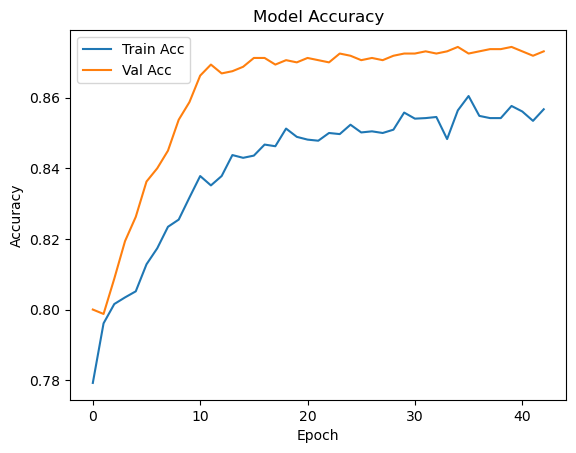

In [19]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
